In [30]:
import h5py
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
from mpl_toolkits import mplot3d 
import trimesh
import pyrender
import nexusformat.nexus as nx
from PIL import Image
import io
import colorsys 
from matplotlib.patches import Rectangle

In [ ]:
 def HSVToRGB(h, s, v): 
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v) 
    return (int(255*r), int(255*g), int(255*b)) 
 
def getDistinctColors(n): 
    huePartition = 1.0 / (n + 1) 
    return np.array(list((HSVToRGB(huePartition * value, .4, .5) for value in range(0, n))))/255.0
        
def draw3DRectangle(ax, x1, y1, z1, x2, y2, z2, color):
#     ax.set_xlim(-2, 2)
#     ax.set_ylim(-2, 2)
#     ax.set_zlim(-2, 2)
    # the Translate the datatwo sets of coordinates form the apposite diagonal points of a cuboid
    ax.plot([x1, x2], [y1, y1], [z1, z1], color=color) # | (up)
    ax.plot([x2, x2], [y1, y2], [z1, z1], color=color) # -->
    ax.plot([x2, x1], [y2, y2], [z1, z1], color=color) # | (down)
    ax.plot([x1, x1], [y2, y1], [z1, z1], color=color) # <--

    ax.plot([x1, x2], [y1, y1], [z2, z2], color=color) # | (up)
    ax.plot([x2, x2], [y1, y2], [z2, z2], color=color) # -->
    ax.plot([x2, x1], [y2, y2], [z2, z2], color=color) # | (down)
    ax.plot([x1, x1], [y2, y1], [z2, z2], color=color) # <--
    
    ax.plot([x1, x1], [y1, y1], [z1, z2], color=color) # | (up)
    ax.plot([x2, x2], [y2, y2], [z1, z2], color=color) # -->
    ax.plot([x1, x1], [y2, y2], [z1, z2], color=color) # | (down)
    ax.plot([x2, x2], [y1, y1], [z1, z2], color=color) # <--

def draw3DRectangleBox(ax, edges, pts, color):
#     ax.set_xlim(-2, 2)
#     ax.set_ylim(-2, 2)
#     ax.set_zlim(-2, 2)
    # the Translate the datatwo sets of coordinates form the apposite diagonal points of a cuboid
    for edge in edges:
        x1, y1, z1 = pts[edge[0]]
        x2, y2, z2 = pts[edge[1]]
        ax.plot([x1, x2], [y1, y2], [z1, z2], color=color) # | (up

    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], color=color)
    
def scatter_pts(pts):
    fig = plt.figure()    
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.view_init(elev=100., azim=-90)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2])
    return

In [5]:
filepath = "/Users/eliwang/physion_data/drop/readout_human_redyellow/pilot_it2_drop_all_bowls_box/0000.hdf5"
filepath = '/Users/eliwang/Downloads/pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_0047.hdf5'
f = h5py.File(filepath)
name = filepath.split('/')[-1].split('.')[0]
# print(nx.nxload(filepath).tree)

In [6]:
print(nx.nxload(filepath).tree)

root:NXroot
  frames:NXgroup
    0000:NXgroup
      camera_matrices:NXgroup
        camera_matrix = float32(16)
        projection_matrix = float32(16)
      collisions:NXgroup
        contacts = float64(27x2x3)
        object_ids = int32(7x2)
        relative_velocities = float64(7x3)
        states = ['enter', 'enter', 'enter', 'enter', 'enter', 'enter', '...
      env_collisions:NXgroup
        contacts = float64(6x2x3)
        object_ids = [4 3]
      images:NXgroup
        _id = uint8(2547)
        _img = uint8(82108)
      labels:NXgroup
        did_fall = False
        has_target = True
        has_zone = True
        target_contacting_zone = False
        target_delta_position = [0. 0. 0.]
        target_has_moved = False
        target_on_ground = False
        trial_complete = False
        trial_end = False
        trial_timeout = False
      objects:NXgroup
        angular_velocities = float32(8x3)
        back = float32(8x3)
        bottom = float32(8x3)
        center = f

In [95]:
def get_camera_matrix(f):
    projection_matrix =  np.array(f['frames']['0000']['camera_matrices']['projection_matrix']).reshape(4,4)
    camera_matrix =  np.array(f['frames']['0000']['camera_matrices']['camera_matrix']).reshape(4,4)
    return np.matmul(projection_matrix, camera_matrix)

def project_points(points, camera_matrix):
    assert points.ndim == 2
    assert points.shape[1] == 3
    
    points = np.pad(points, [(0,0), (0,1)], constant_values=1).T
    projected_points = np.matmul(camera_matrix, points).T
    projected_points = projected_points / projected_points[:,-1:]
    return projected_points

def compute_bbox_from_projected_pts(points):
    assert points.ndim == 2
    assert points.shape[1] == 4
    x1 = np.min(points[:,0])
    y1 = np.min(-points[:,1]) # flip y
    x2 = np.max(points[:,0])
    y2 = np.max(-points[:,1]) # flip y
    xyxy = rescale_xyxy(np.array([x1, y1, x2, y2]))
    return xyxy

def compute_bboxes(points, f):
    camera_matrix = get_camera_matrix(f)
    ppoints = project_points(points, camera_matrix)
    xyxy = compute_bbox_from_projected_pts(ppoints)
    return xyxy

def rescale_xyxy(xyxy):
    xyxy = np.clip(xyxy, -1, 1) # ensure [-1,1]
    xyxy = (xyxy + 1.) / 2. # scale to [0,1]
    return xyxy

def get_vertices_scaled(f, obj_id):
    
    vertices_orig = np.array(f['static']['mesh']['vertices_' + str(obj_id)])

    scales = f["static"]["scale"][:]

    vertices_orig[:,0] *= scales[obj_id, 0]
    vertices_orig[:,1] *= scales[obj_id, 1]
    vertices_orig[:,2] *= scales[obj_id, 2]
    faces_orig = np.array(f['static']['mesh']['faces_' + str(obj_id)])
    
    return vertices_orig, faces_orig

def get_full_bbox(vertices):
    arr1 = vertices.min(0)
    
    arr2 = vertices.max(0)
    
    arr = np.stack([arr1, arr2], 0)
    
    pts = [(0, 0, 0), (0, 0, 1), (0, 1, 1), (0, 1, 0) , (1, 0, 0), (1, 0, 1), (1, 1, 1), (1, 1, 0)]
         
    all_edges = [(0, 1), (1, 2), (2, 3), (3, 0),  (4, 5), (5, 6), (6, 7), (7, 4), (0, 4), (1, 5), (2, 6), (3, 7)]
    
    all_faces = [(0, 1, 2, 3), (4, 5, 6, 7), (2, 3, 6, 7), (1, 0, 4, 5), (1, 2, 6, 5), \
                (0, 4, 7, 3)]    
    
    index = np.arange(3)
    
    all_pts = []
    for pt in pts:
        p1 = arr[pt, index]
        all_pts.append(p1)
    
    all_pts = np.stack(all_pts, 0)
    
    return all_pts, all_edges, all_faces    


def get_transformed_pts(f, pts, frame, obj_id):
    rotations_0 = np.array(f['frames'][frame]['objects']['rotations'][obj_id])
    positions_0 = np.array(f['frames'][frame]['objects']['positions'][obj_id])
    
    rot = R.from_quat(rotations_0).as_matrix()
    trans = positions_0
    transformed_pts = np.matmul(rot, pts.T).T + np.expand_dims(trans, axis=0)
    
    return transformed_pts

def bbox_to_corners(x1, y1, x2, y2):
    return [(x,y) for x in [x1,x2] for y in [y1,y2]]

def get_frame(frame_no, lbl='_img'):
    frame = str(frame_no).zfill(4)
    img = f['frames'][frame]['images'][lbl][()]
    img = Image.open(io.BytesIO(img)) # (256, 256, 3)
    return np.array(img)

def get_ax(fig):
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-0.5, 2)
    ax.set_zlim(-2, 2)
    ax.view_init(elev=30., azim=30, vertical_axis='y')
    return ax

def plot_box(pts, colors, close=False):
    fig = plt.figure(figsize=[20, 20])
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.view_init(elev=100., azim=-90)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=colors)
    return fig

def xyxy_to_xywh(x1, y1, x2, y2):
    x = (x1+x2)/2
    y = (y1+y2)/2
    w = (x2-x1)/2
    h = (y2-y1)/2
    return x,y,w,h

def xywh_to_xyxy(x, y, w, h):
    x1 = x - w
    x2 = x + w
    y1 = y - h
    y2 = y + h
    return x1,y1,x2,y2

def compute_bboxes_from_mask(id_img, tol=0.1):
    colors = np.unique(id_img.reshape(-1, id_img.shape[2]), axis=0)
    bboxes = []
    for color in colors:
        if not color.any(): # all zeros
            continue
        idxs = np.argwhere(id_img==color)
        x1 = np.min(idxs[:,1])
        x2 = np.max(idxs[:,1])
        y1 = np.min(idxs[:,0])
        y2 = np.max(idxs[:,0])
        xyxy = np.array([x1,y1,x2,y2])
        x,y,w,h = xyxy_to_xywh(*xyxy)
        w, h = w*(1+tol), h*(1+tol)
        xyxy = np.clip(xywh_to_xyxy(x,y,w,h), 0, id_img.shape[0]-1)
        bboxes.append(xyxy)
    return bboxes

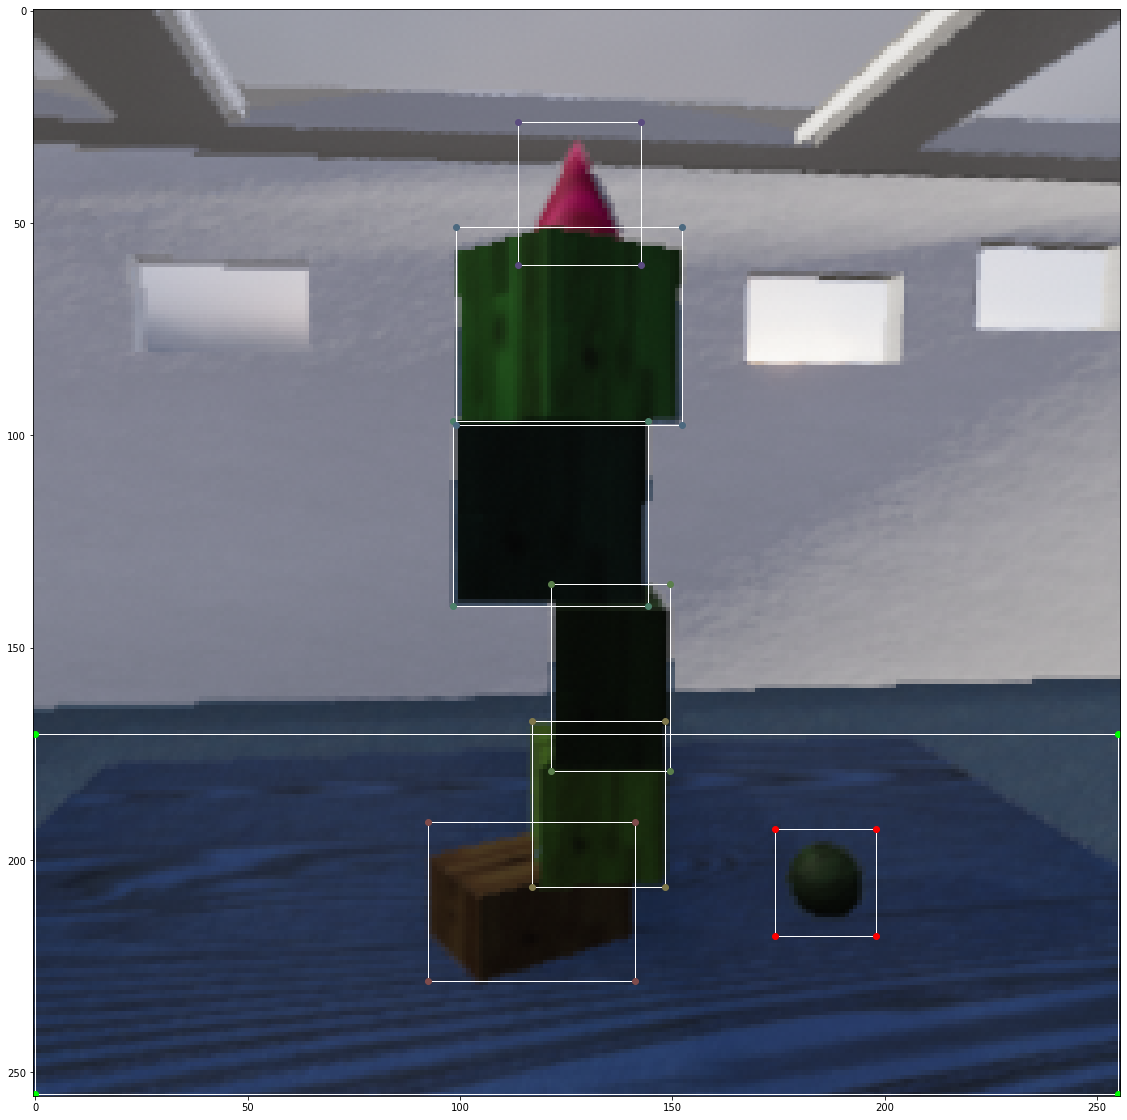

In [102]:
filepath = "/Users/eliwang/physion_data/drop/readout_human_redyellow/pilot_it2_drop_all_bowls_box/0000.hdf5"
filepath = '/Users/eliwang/Downloads/pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_0047.hdf5'
f = h5py.File(filepath)

object_ids = np.array(f['static']['object_ids'])
colors = [[0, 1, 0], [1, 0, 0]] + list(getDistinctColors(len(object_ids)-2))

for frame_no in range(0, 10, 10):
    plt.figure(figsize=(20,20))
    rgb_img = get_frame(frame_no, '_img')
    id_img = get_frame(frame_no, '_id')
    plt.imshow(rgb_img)
    for i, obj_id in enumerate(object_ids):
        obj_id = i #obj_id-1    

        vertices_orig, faces_orig = get_vertices_scaled(f, obj_id)

        all_pts, all_edges, all_faces = get_full_bbox(vertices_orig)

        frame_pts = get_transformed_pts(f, all_pts, str(frame_no).zfill(4), obj_id)
        xyxy = compute_bboxes(frame_pts, f)*255
        
        corners = bbox_to_corners(*xyxy)
        
        currentAxis = plt.gca()
        currentAxis.add_patch(Rectangle((xyxy[0],xyxy[1]), xyxy[2]-xyxy[0], xyxy[3]-xyxy[1], fill=None, alpha=1, color='w'))
        for c in corners:
            plt.scatter(c[0], c[1], color=colors[obj_id])
    plt.show()

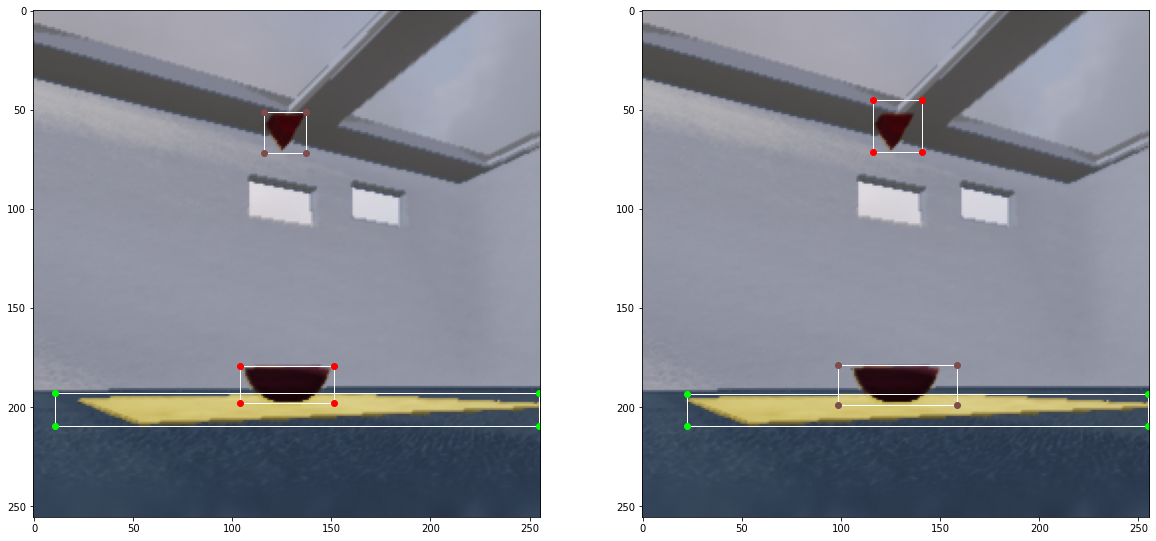

In [111]:
filepath = "/Users/eliwang/physion_data/drop/readout_human_redyellow/pilot_it2_drop_all_bowls_box/0001.hdf5"
# filepath = '/Users/eliwang/Downloads/pilot_towers_nb5_fr015_SJ030_mono0_dis0_occ0_boxroom_0047.hdf5'
f = h5py.File(filepath)

object_ids = np.array(f['static']['object_ids'])
colors = [[0, 1, 0], [1, 0, 0]] + list(getDistinctColors(len(object_ids)-2))

for frame_no in range(0, 10, 10):
    _, axarr = plt.subplots(1,2, figsize=(20,20))
    rgb_img = get_frame(frame_no, '_img')
    id_img = get_frame(frame_no, '_id')
    axarr[0].imshow(rgb_img)
    bboxes = compute_bboxes_from_mask(id_img)
    for obj_id, xyxy in enumerate(bboxes):
        corners = bbox_to_corners(*xyxy)
        
        axarr[0].add_patch(Rectangle((xyxy[0],xyxy[1]), xyxy[2]-xyxy[0], xyxy[3]-xyxy[1], fill=None, alpha=1, color='w'))
        for c in corners:
            axarr[0].scatter(c[0], c[1], color=colors[obj_id])
    
    rgb_img = get_frame(frame_no, '_img')
    id_img = get_frame(frame_no, '_id')
    axarr[1].imshow(rgb_img)
    for i, obj_id in enumerate(object_ids):
        obj_id = i #obj_id-1    

        vertices_orig, faces_orig = get_vertices_scaled(f, obj_id)

        all_pts, all_edges, all_faces = get_full_bbox(vertices_orig)

        frame_pts = get_transformed_pts(f, all_pts, str(frame_no).zfill(4), obj_id)
        xyxy = compute_bboxes(frame_pts, f)*255
        
        corners = bbox_to_corners(*xyxy)
        
        axarr[1].add_patch(Rectangle((xyxy[0],xyxy[1]), xyxy[2]-xyxy[0], xyxy[3]-xyxy[1], fill=None, alpha=1, color='w'))
        for c in corners:
            axarr[1].scatter(c[0], c[1], color=colors[obj_id])
    plt.show()

In [49]:
import subprocess
import cv2
def write_video(file_path, frames, fps):
    """
    Writes frames to an mp4 video file
    :param file_path: Path to output video, must end with .mp4
    :param frames: List of PIL.Image objects
    :param fps: Desired frame rate
    """

    h, w = frames[0].shape[:2]
    fourcc = cv2.cv2.VideoWriter_fourcc(*"MJPG")# cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

    for frame in frames:
        writer.write((frame[:, :, :3]*255).astype('uint8'))

    writer.release() 

In [58]:
write_video(name + '.avi', all_imgs, 30)

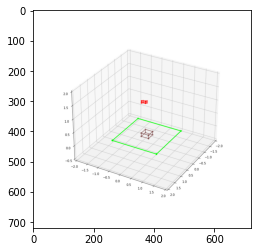

In [8]:
plt.imshow(all_imgs[0])